<a href="https://colab.research.google.com/github/Satwikram/Computer-Vision-Implementations/blob/main/Lime%20for%20Image%20Classification%20using%20tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Imports

In [ ]:
import tensorflow as tf

import os

from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Dataset

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

 95% 208M/218M [00:01<00:00, 210MB/s]
100% 218M/218M [00:01<00:00, 221MB/s]


In [ ]:
!unzip /content/cat-and-dog.zip

In [ ]:
inet_model = inc_net.InceptionV3()

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

### Let's see the top 5 prediction for some image

49152/35363 [=========================================] - 0s 0us/step
('n02123045', 'tabby', 0.7514501)
('n02124075', 'Egyptian_cat', 0.11022686)
('n02123159', 'tiger_cat', 0.03338068)
('n04356056', 'sunglasses', 0.0016435875)
('n04589890', 'window_screen', 0.0012620843)


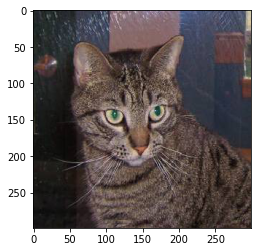

In [ ]:
images = transform_img_fn([os.path.join('/content/training_set/training_set/cats','cat.1.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

('n02099849', 'Chesapeake_Bay_retriever', 0.65377915)
('n02105412', 'kelpie', 0.088502675)
('n02099712', 'Labrador_retriever', 0.035251707)
('n02099429', 'curly-coated_retriever', 0.0028395888)
('n02093428', 'American_Staffordshire_terrier', 0.002338063)


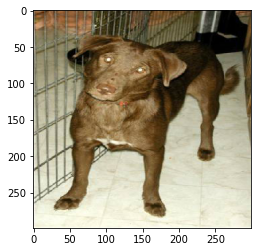

In [ ]:
images = transform_img_fn([os.path.join('/content/training_set/training_set/dogs','dog.1.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

### Explanation

In [ ]:
!pip install lime

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 21.6 s, sys: 572 ms, total: 22.2 s
Wall time: 25.8 s


Now let's see the explanation for the top class

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [ ]:
from skimage.segmentation import mark_boundaries

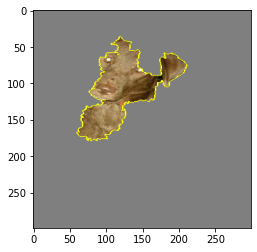

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### With the rest of the image present:

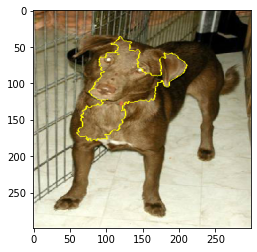

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### We can also see the 'pros and cons' (pros in green, cons in red)

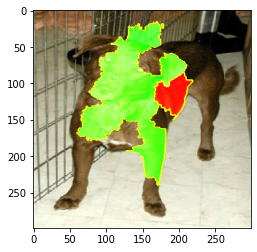

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Or the pros and cons that have weight at least 0.1

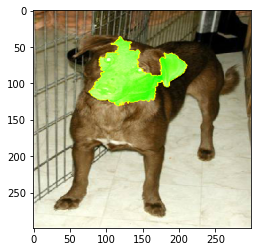

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.


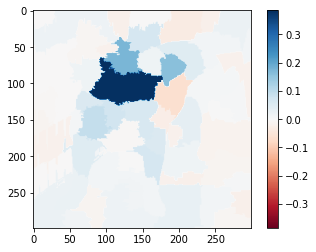

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()